# Assignment for Week 8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Final Project     

Week's 8 assignment will be work towards the final project.    

### About Final Project     


The final project will be a competition submission to any of the platforms available such as Kaggle. The competition will require to either build a Linear Regression or Logistic Regression model. 

The instructor will notify students by week 7 on the competition and the submissions.  This competition will include some or all the material and skills learned in the course.

Students are required to submit the final version of work/codes as a Jupyter Notebook via colab as submitted to the competition along with the link to their account pointing to their score on the competition's board. This will be evaluated and graded for the entire project for the duration of week 8-12. 



## Tasks

**Required:**    

*   Open an account to the decided competition's platform and download the data sets (train, test, etc) needed to compete.    
*   Start working with your data, get to know the data. Read all the competition information provided to the hosting platform. Try to get familiar with the data, topic, etc.      
*   Submit the link of your competition's account via BlueQuill. 

**Pump-it Up Water Project - Tanzanian Ministry of Water**

Competition Challenge - using data from "Taarifa" and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition.

Predict one of these three classes based on several variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which water points will fail can improve maintenance operaations and ensure that clean, potable water is available to communities across Tanzania.

A training dataset with information of nearly sixty thousand water points across Tanzania is provided its use is expected to build a model that will be able to predict which water points are functional, nonfunctional, and functional but need repair on a test dataset.

**DATA DOWNLOAD SECTION FROM GITHUB ACCOUNT**

In [9]:
# Let's load pandas and see the first few rows of data of the Pump-it Up datasets (Train and Test).
import pandas as pd
import os
import sys
water = pd.read_csv('https://raw.githubusercontent.com/bradley1958/DATA612_FINAL_PROJECT/master/Well_Water_19K_Mod.csv')
water_test = pd.read_csv('https://raw.githubusercontent.com/bradley1958/DATA612_FINAL_PROJECT/master/Well_Water_5K.csv')
water.head()




,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_group_name,source_type_name,quality_group_name
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,False,1999,gravity,gravity,1,vwc,user-group,pay annually,3,soft,1,1,enough,spring,1,groundwater,1,communal standpipe,1,functional,spring,good
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,True,2010,gravity,gravity,1,wug,user-group,never pay,1,soft,1,2,insufficient,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,True,2009,gravity,gravity,1,vwc,user-group,pay per bucket,5,soft,1,1,enough,dam,3,surface,1,communal standpipe,1,functional,dam,good
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,True,1986,submersible,submersible,6,vwc,user-group,never pay,1,soft,1,0,dry,machine dbh,4,groundwater,1,communal standpipe,0,non functional,borehole,good
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,True,0,gravity,gravity,1,other,other,never pay,1,soft,1,3,seasonal,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good


In [10]:
water['status_group_name'].unique()


array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [11]:
water['status_group'].unique()

array([1, 0, 2])

In [12]:
water_test.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,True,2012,other,4,parastatal,parastatal,never pay,1,soft,good,3,seasonal,rainwater harvesting,2,surface,3,other
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,True,2000,gravity,1,vwc,user-group,never pay,1,soft,good,2,insufficient,spring,1,groundwater,1,communal standpipe
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,NaN,2010,other,4,vwc,user-group,never pay,1,soft,good,2,insufficient,rainwater harvesting,2,surface,3,other
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,True,1987,other,4,vwc,user-group,unknown,7,soft,good,0,dry,shallow well,6,groundwater,3,other
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,True,2000,gravity,1,water board,user-group,pay monthly,4,soft,good,1,enough,spring,1,groundwater,1,communal standpipe


In [13]:
water.shape, water_test.shape

((59400, 41), (14850, 36))

**This shows we have mis-matched data frames. We will have to take care of this later before running are models and making our prediction(s) for export to a csv file.**

In [14]:
water_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   funder                 13981 non-null  object 
 3   gps_height             14850 non-null  int64  
 4   installer              13973 non-null  object 
 5   longitude              14850 non-null  float64
 6   latitude               14850 non-null  float64
 7   wpt_name               14850 non-null  object 
 8   num_private            14850 non-null  int64  
 9   basin                  14850 non-null  object 
 10  subvillage             14751 non-null  object 
 11  region                 14850 non-null  object 
 12  region_code            14850 non-null  int64  
 13  district_code          14850 non-null  int64  
 14  lga                    14850 non-null  object 
 15  wa

**LOADING PANDAS FEATURES FOR USE IN OUR TANZANIAN WATER PROJECT**

In [15]:
# Let's load additional pandas features
import time
import seaborn as sns
import warnings
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import matplotlib.image as mpimg
import numpy as np
import pydotplus
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals.six import StringIO
from sklearn import tree
import scipy.stats as stats
from pandas import set_option
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.decomposition import PCA
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
import scipy





In [16]:
# Let's take a quick look at our Well Pump counts by Region
region = water.groupby('status_group_name')[['region']].count()
print(region)


                         region
status_group_name              
functional                32259
functional needs repair    4317
non functional            22824


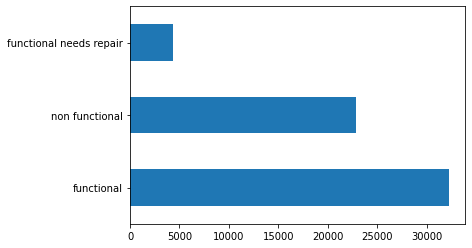

In [17]:
# Let's see a quick Bar Chart of our Target Variable (Status Group) followed by the counts for each value.
water.status_group_name.value_counts().plot(kind='barh')
plt.show()

In [19]:
# The value Counts.
well_status = water.groupby('status_group_name').count()
print(well_status)

                            id  ...  quality_group_name
status_group_name               ...                    
functional               32259  ...               32259
functional needs repair   4317  ...                4317
non functional           22824  ...               22824

[3 rows x 40 columns]


So, from this we see that we have 32,259 functional wells in all regions, with 22,824 non functional wells throughout the regions, plus an additional 4,317 wells that need repair throughout the regions.

**DATA CLEANING SECTION (TRAINING SET)**

Next we are going to clean the data of all zero's in the "int64" Dtypes, basically the columns we will be using to run or predictive modeling off of. I will change the zero's to the median value in both Train/Test datasets. The columns being cleaned up are: "construction_year", "population", and "gps_height".

In [20]:
# Let's try and replace our zero's in the Construction Year, Population, and Gps_Height Column's with the "median value" for each data element
print(water['construction_year'].median())


1986.0


In [21]:
water['construction_year'] = water['construction_year'].replace(0, 1986.0)
water.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_group_name,source_type_name,quality_group_name
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,False,1999,gravity,gravity,1,vwc,user-group,pay annually,3,soft,1,1,enough,spring,1,groundwater,1,communal standpipe,1,functional,spring,good
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,True,2010,gravity,gravity,1,wug,user-group,never pay,1,soft,1,2,insufficient,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,True,2009,gravity,gravity,1,vwc,user-group,pay per bucket,5,soft,1,1,enough,dam,3,surface,1,communal standpipe,1,functional,dam,good
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,True,1986,submersible,submersible,6,vwc,user-group,never pay,1,soft,1,0,dry,machine dbh,4,groundwater,1,communal standpipe,0,non functional,borehole,good
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,True,1986,gravity,gravity,1,other,other,never pay,1,soft,1,3,seasonal,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good


In [22]:
print(water['population'].median())

25.0


In [ ]:
water['population'] = water['population'].replace(0, 25.0)
water.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_group_name,source_type_name,quality_group_name
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,False,1999,gravity,gravity,1,vwc,user-group,pay annually,3,soft,1,1,enough,spring,1,groundwater,1,communal standpipe,1,functional,spring,good
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,True,2010,gravity,gravity,1,wug,user-group,never pay,1,soft,1,2,insufficient,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,True,2009,gravity,gravity,1,vwc,user-group,pay per bucket,5,soft,1,1,enough,dam,3,surface,1,communal standpipe,1,functional,dam,good
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,True,1986,submersible,submersible,6,vwc,user-group,never pay,1,soft,1,0,dry,machine dbh,4,groundwater,1,communal standpipe,0,non functional,borehole,good
4,19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,25,True,GeoData Consultants Ltd,True,1986,gravity,gravity,1,other,other,never pay,1,soft,1,3,seasonal,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good


In [23]:
print(water['gps_height'].median())

369.0


In [24]:
water['gps_height'] = water['gps_height'].replace(0, 369.0)
water.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_group_name,source_type_name,quality_group_name
0,69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,False,1999,gravity,gravity,1,vwc,user-group,pay annually,3,soft,1,1,enough,spring,1,groundwater,1,communal standpipe,1,functional,spring,good
1,8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,True,2010,gravity,gravity,1,wug,user-group,never pay,1,soft,1,2,insufficient,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good
2,34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,True,2009,gravity,gravity,1,vwc,user-group,pay per bucket,5,soft,1,1,enough,dam,3,surface,1,communal standpipe,1,functional,dam,good
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,True,1986,submersible,submersible,6,vwc,user-group,never pay,1,soft,1,0,dry,machine dbh,4,groundwater,1,communal standpipe,0,non functional,borehole,good
4,19728,0.0,Action In A,369,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,True,1986,gravity,gravity,1,other,other,never pay,1,soft,1,3,seasonal,rainwater harvesting,2,surface,1,communal standpipe,1,functional,rainwater harvesting,good


In [25]:
# Let's check for null values
water.apply(lambda x: sum(x.isnull()))

id                          0
amount_tsh                  0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                371
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
recorded_by                 0
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_vals                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_typ

**Wow, several feature variables have huge null value counts** - permit, public_meeting, subvillage, installer, and funder. These features will not be used in our model runs. 

**DATA EXPLORATION (TRAINING SET)**

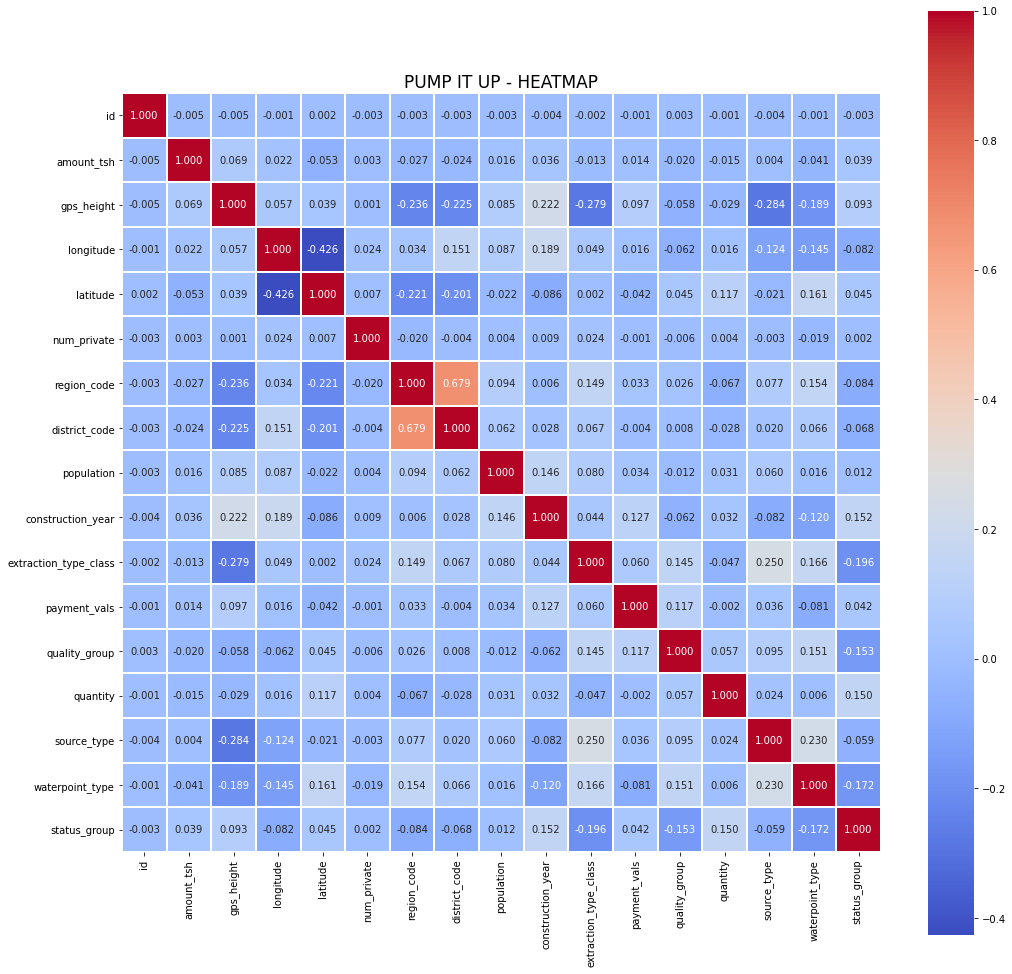

In [26]:
# Let's do a Correlation Matrix 
corr = water.corr()
f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(corr, square=True, cbar=True, annot=True, fmt='.3f',
            xticklabels=True, yticklabels=True, 
            cmap="coolwarm", linewidth=1, ax=ax)
plt.title('PUMP IT UP - HEATMAP', size=17);



From the above seaborn heat map we can see that the following features have a strong correlation to predicting functionality of any given well throughout Tanzanian. Those features are "construction_year", "district_code', "longitude", "latitude", "gps_height", and "region_code". To a lesser extent we have "extraction_type_Class", "quantity', and "payment_type".

In [27]:
# Let's see the Numeric Coding for the Waterpoint Type
water_type = water.groupby('status_group_name')[['waterpoint_type']].count()
print(water_type)

                         waterpoint_type
status_group_name                       
functional                         32259
functional needs repair             4317
non functional                     22824


In [28]:
# Let's see the above sum of the Waterpoint Type
water_type = water.groupby('waterpoint_type_group')[['status_group_name']].count().sum()
print(water_type)

status_group_name    59400
dtype: int64


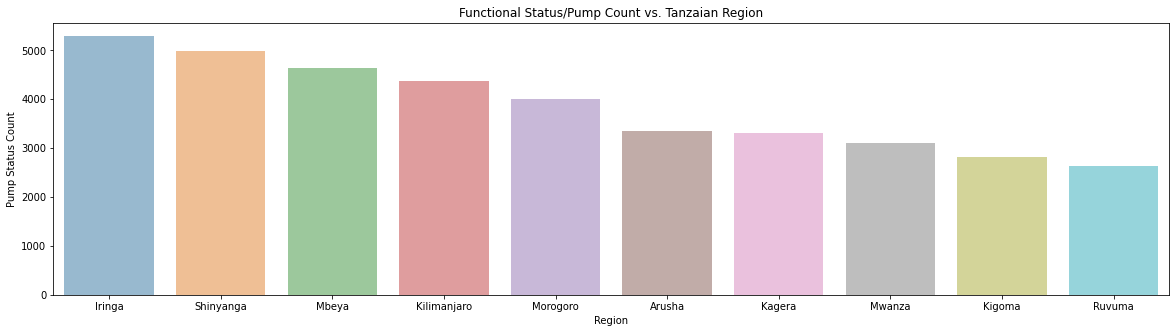

In [29]:
# Let's look at the Top 10 Regional areas - Looking at the total Well Pump Count
region_count = water['region'].value_counts()
region_count = region_count[:10,]
plt.figure(figsize=(20,5))
sns.barplot(region_count.index, region_count.values, alpha=0.5)
plt.title('Functional Status/Pump Count vs. Tanzaian Region')
plt.ylabel('Pump Status Count')
plt.xlabel('Region')
plt.show()





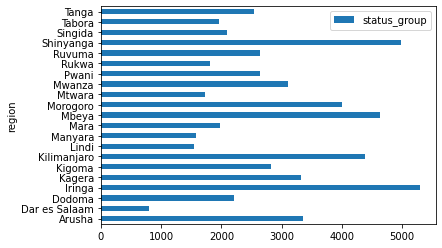

In [ ]:
 # Let's create a count of Status Group values by Region with a Bar Chart
region = water.groupby('region')[['status_group']].count()
region.plot(kind='barh')


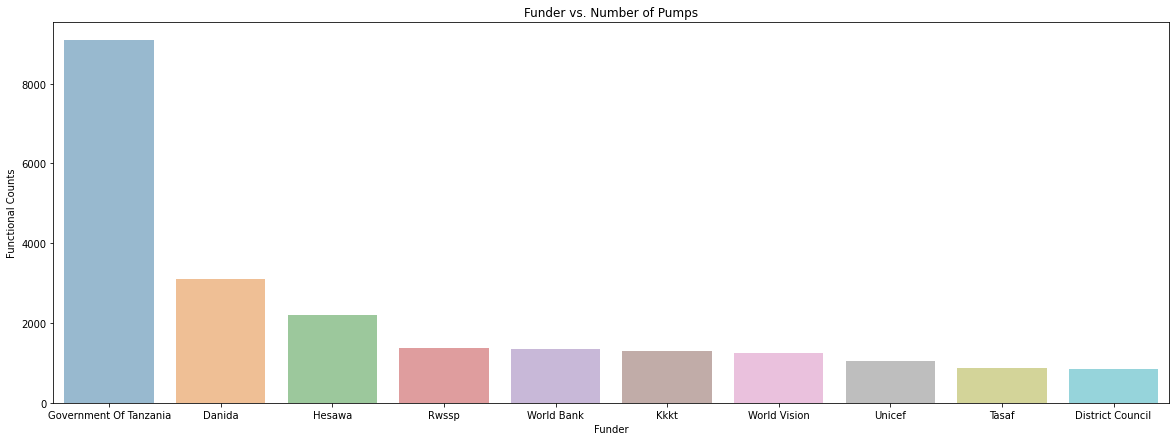

In [30]:
# let's look at the Funding vs. Number of Pumps for the Top 10 Agencys
funder_count = water['funder'].value_counts()
funder_count = funder_count[:10,]
plt.figure(figsize=(20,7))
sns.barplot(funder_count.index, funder_count.values, alpha=0.5)
plt.title('Funder vs. Number of Pumps')
plt.ylabel('Functional Counts')
plt.xlabel('Funder')
plt.show()

In [31]:
funder =water.groupby('funder')[['status_group_name']].count()
print(funder)

                     status_group_name
funder                                
0                                  777
A/co Germany                        15
Aar                                 33
Abas Ka                              1
Abasia                              43
...                                ...
Zao                                  1
Zao Water Spring                     3
Zao Water Spring X                   1
Zinduka                              1
Zingibali Secondary                  1

[1897 rows x 1 columns]


This shows us that the Tanzanian Government has funded the most wells.

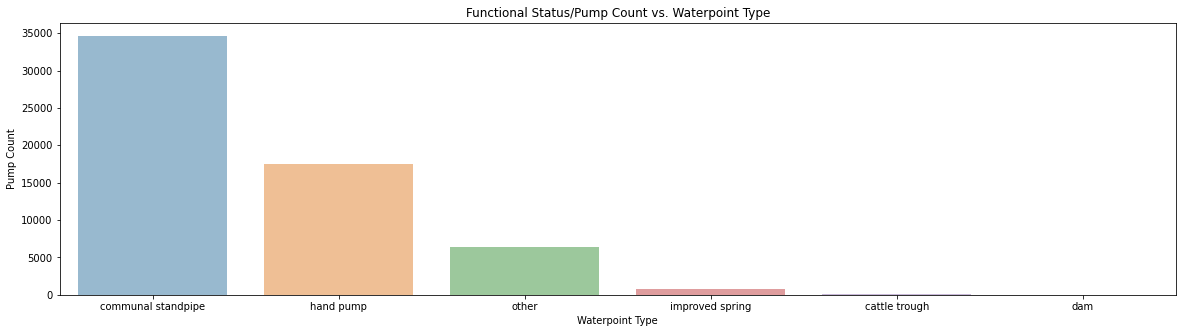

In [32]:
# This chart gives us a Total Well Pummp count for each Waterpoint Type
pump_count = water['waterpoint_type_group'].value_counts()
pump_count = pump_count[:7,]
plt.figure(figsize=(20,5))
sns.barplot(pump_count.index, pump_count.values, alpha=0.5)
plt.title('Functional Status/Pump Count vs. Waterpoint Type')
plt.ylabel('Pump Count')
plt.xlabel('Waterpoint Type')
plt.show()

This shows us that the most common type well is the "communal standpipe". The number grakeouts are printed below.

In [33]:
# Let's show the numeric counts of the above bar chart.
water_type = water.groupby('waterpoint_type_group')[['status_group']].count()
print(water_type)



                       status_group
waterpoint_type_group              
cattle trough                   116
communal standpipe            34625
dam                               7
hand pump                     17488
improved spring                 784
other                          6380


Next, let's try some pivot tables to drill down into some of this information and perhaps get a better feel for the numbers associated with some of the features of our dataset.

In [34]:
piv_table = pd.pivot_table(water,index=['basin','status_group_name'],
                           values='status_group', aggfunc='count')
piv_table

status_group
basin                   status_group_name                    
Internal                functional                       4482
                        functional needs repair           557
                        non functional                   2746
Lake Nyasa              functional                       3324
                        functional needs repair           250
                        non functional                   1511
Lake Rukwa              functional                       1000
                        functional needs repair           270
                        non functional                   1184
Lake Tanganyika         functional                       3107
                        functional needs repair           742
                        non functional                   2583
Lake Victoria           functional                       5100
                        functional needs repair           989
                        non functional                   4159
Pangani                 functional                       5372
                        functional needs repair           477
                        non functional                   3091
Rufiji                  functional                       5068
                        functional needs repair           437
                        non functional                   2471
Ruvuma / Southern Coast functional                       1670
                        functional needs repair           326
                        non functional                   2497
Wami / Ruvu             functional                       3136
                        functional needs repair           269
                        non functional                   2582

Interesting that Lake Victoria has the highest number of functioning wells, and the highest number of non functioning wells.

In [35]:
piv_table = pd.pivot_table(water,index=['quantity_group','status_group_name'],
                           values='status_group', aggfunc='count')
piv_table

status_group
quantity_group status_group_name                    
dry            functional                        157
               functional needs repair            37
               non functional                   6052
enough         functional                      21648
               functional needs repair          2400
               non functional                   9138
insufficient   functional                       7916
               functional needs repair          1450
               non functional                   5763
seasonal       functional                       2325
               functional needs repair           416
               non functional                   1309
unknown        functional                        213
               functional needs repair            14
               non functional                    562

I would have thought that a dry well would not be functioning, but as you can see above supposedly 157 are. Also, the "group" insufficient has a high number of both functional and non functional wells.

In [36]:
piv_table = pd.pivot_table(water,index=['source_class','status_group_name'],
                           values='status_group', aggfunc='count')
piv_table

status_group
source_class status_group_name                    
groundwater  functional                      24835
             functional needs repair          2741
             non functional                  18218
surface      functional                       7266
             functional needs repair          1571
             non functional                   4491
unknown      functional                        158
             functional needs repair             5
             non functional                    115

Interesting that groundwater has both the highest functional and non functional wells. I would have thought that surface water would have had the highest number for non functional wells with seasonal drought conditions (above and below Equatorial Afica). 

In [37]:
piv_table = pd.pivot_table(water,index=['extraction_type_group','status_group_name'],
                           values='status_group', aggfunc='count')
piv_table

status_group
extraction_type_group status_group_name                    
afridev               functional                       1200
                      functional needs repair            42
                      non functional                    528
gravity               functional                      16048
                      functional needs repair          2701
                      non functional                   8031
india mark ii         functional                       1448
                      functional needs repair            79
                      non functional                    873
india mark iii        functional                         44
                      functional needs repair             1
                      non functional                     53
mono                  functional                       1082
                      functional needs repair           129
                      non functional                   1654
nira/tanira           functional                       5421
                      functional needs repair           641
                      non functional                   2092
other                 functional                       1029
                      functional needs repair           206
                      non functional                   5195
other handpump        functional                        172
                      functional needs repair            20
                      non functional                    172
other motorpump       functional                         53
                      functional needs repair             9
                      non functional                     60
rope pump             functional                        293
                      functional needs repair            17
                      non functional                    141
submersible           functional                       3329
                      functional needs repair           253
                      non functional                   2597
swn 80                functional                       2090
                      functional needs repair           212
                      non functional                   1368
wind-powered          functional                         50
                      functional needs repair             7
                      non functional                     60

It looks like the "handpump" method of water extraction has the most non functional wells, while the "nira/tanira" method has the most functional wells.

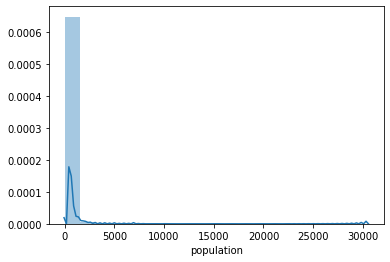

In [38]:
sns.distplot(water.population, bins=20)
plt.show()

Interesting, it looks like most of the population centers that are holding against wells are very small. I guess that makes sense in for Africa.

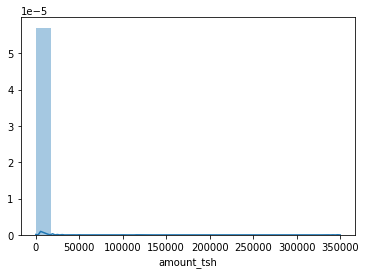

In [39]:
# Let's look at the amount of water available at the pump.
sns.distplot(water.amount_tsh, bins=20)
plt.show()

This similar to the Population chart, and I guess that males sense since the two features go hand-in-hand.

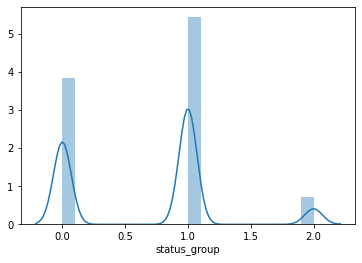

In [40]:
# let's look at the distribution graph of our functional well status.
sns.distplot(water.status_group, bins=20)
plt.show()

I just wanted to see what kind of distribution the graph/chart would show for the three different values. Functional is the high peak, Non Functional the second highest peak, and Needs Repair is the low peak.

**CLEANING THE ZERO VALUES FROM THE TEST SET**

In [41]:
# Next, let's do the same to the Test Set
print(water_test['population'].median())

20.0


In [42]:
water_test['population'] = water_test['population'].replace(0, 20.0)
water_test.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,True,2012,other,4,parastatal,parastatal,never pay,1,soft,good,3,seasonal,rainwater harvesting,2,surface,3,other
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,True,2000,gravity,1,vwc,user-group,never pay,1,soft,good,2,insufficient,spring,1,groundwater,1,communal standpipe
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,NaN,2010,other,4,vwc,user-group,never pay,1,soft,good,2,insufficient,rainwater harvesting,2,surface,3,other
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,True,1987,other,4,vwc,user-group,unknown,7,soft,good,0,dry,shallow well,6,groundwater,3,other
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,True,2000,gravity,1,water board,user-group,pay monthly,4,soft,good,1,enough,spring,1,groundwater,1,communal standpipe


In [43]:
print(water_test['gps_height'].median())


344.0


In [44]:
water_test['gps_height'] = water_test['gps_height'].replace(0, 344.0)
water_test.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,True,2012,other,4,parastatal,parastatal,never pay,1,soft,good,3,seasonal,rainwater harvesting,2,surface,3,other
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,True,2000,gravity,1,vwc,user-group,never pay,1,soft,good,2,insufficient,spring,1,groundwater,1,communal standpipe
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,NaN,2010,other,4,vwc,user-group,never pay,1,soft,good,2,insufficient,rainwater harvesting,2,surface,3,other
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,True,1987,other,4,vwc,user-group,unknown,7,soft,good,0,dry,shallow well,6,groundwater,3,other
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,True,2000,gravity,1,water board,user-group,pay monthly,4,soft,good,1,enough,spring,1,groundwater,1,communal standpipe


In [45]:
print(water_test['construction_year'].median())

1986.0


In [46]:
water_test['construction_year'] = water_test['construction_year'].replace(0, 1986.0)
water_test.head(5)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,permit,construction_year,extraction_type_group,extraction_type_class,management,management_group,payment,payment_vals,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,True,2012,other,4,parastatal,parastatal,never pay,1,soft,good,3,seasonal,rainwater harvesting,2,surface,3,other
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,True,2000,gravity,1,vwc,user-group,never pay,1,soft,good,2,insufficient,spring,1,groundwater,1,communal standpipe
2,17168,0.0,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,NaN,2010,other,4,vwc,user-group,never pay,1,soft,good,2,insufficient,rainwater harvesting,2,surface,3,other
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,True,1987,other,4,vwc,user-group,unknown,7,soft,good,0,dry,shallow well,6,groundwater,3,other
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,True,2000,gravity,1,water board,user-group,pay monthly,4,soft,good,1,enough,spring,1,groundwater,1,communal standpipe


In [47]:
# Train and Test are different shapes. Find which columns are different.
water.columns.difference(water_test.columns)

Index(['extraction_type', 'quality_group_name', 'source_type_name',
       'status_group', 'status_group_name'],
      dtype='object')

In [48]:
water_test.columns.difference(water.columns)

Index([], dtype='object')

In [49]:
# Drop the columns that are different excluding the target (status_group_name)
water.drop(columns= ['quality_group_name','source_type_name','status_group_name','extraction_type'], inplace=True)

In [50]:
water.shape, water_test.shape

((59400, 37), (14850, 36))

In [51]:
# Let's create a sub-set for our Training Set
subset_train = water[['id','amount_tsh','gps_height','region_code','district_code','population','construction_year','quantity','source_type','waterpoint_type','status_group','extraction_type_class','longitude','latitude','payment_vals']]
subset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   region_code            59400 non-null  int64  
 4   district_code          59400 non-null  int64  
 5   population             59400 non-null  int64  
 6   construction_year      59400 non-null  int64  
 7   quantity               59400 non-null  int64  
 8   source_type            59400 non-null  int64  
 9   waterpoint_type        59400 non-null  int64  
 10  status_group           59400 non-null  int64  
 11  extraction_type_class  59400 non-null  int64  
 12  longitude              59400 non-null  float64
 13  latitude               59400 non-null  float64
 14  payment_vals           59400 non-null  int64  
dtypes:

In [52]:
# Let's create a sub-set for our Test Set
subset_test = water_test[['id','amount_tsh','gps_height','num_private','region_code','district_code','population','construction_year','quantity','source_type','waterpoint_type','extraction_type_class','longitude','latitude','payment_vals']]
subset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   gps_height             14850 non-null  int64  
 3   num_private            14850 non-null  int64  
 4   region_code            14850 non-null  int64  
 5   district_code          14850 non-null  int64  
 6   population             14850 non-null  int64  
 7   construction_year      14850 non-null  int64  
 8   quantity               14850 non-null  int64  
 9   source_type            14850 non-null  int64  
 10  waterpoint_type        14850 non-null  int64  
 11  extraction_type_class  14850 non-null  int64  
 12  longitude              14850 non-null  float64
 13  latitude               14850 non-null  float64
 14  payment_vals           14850 non-null  int64  
dtypes:

So, now we have equal columns between the Training Set and the Testing Set for our Tanzanian Well Pump data. We will be running our models with 15 features.

In [68]:
# Feature Set
X = subset_train.drop(columns= ['status_group']).values
y = subset_train['status_group'].values

In [69]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [70]:
print('Training Set: ', X_train.shape, y_train.shape)
print('Testing Set: ', X_test.shape, y_test.shape)

Training Set:  (44550, 14) (44550,)
Testing Set:  (14850, 14) (14850,)


Accuracy:  0.6191245791245791

              precision    recall  f1-score   support

           0       0.66      0.39      0.49      5811
           1       0.61      0.87      0.71      7963
           2       0.00      0.00      0.00      1076

    accuracy                           0.62     14850
   macro avg       0.42      0.42      0.40     14850
weighted avg       0.58      0.62      0.58     14850


Average 5 Fold CV Score: 0.6198 , Standard Deviation: 0.0035


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


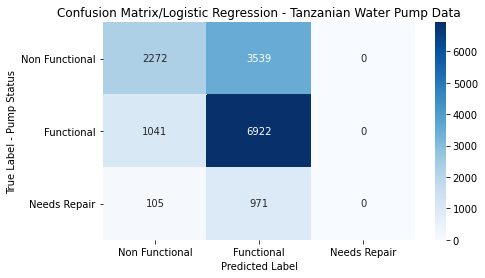

In [56]:
# let's try Logistic Regression
LR = LogisticRegression(C=0.00008, random_state=123)
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_pred, y_test))

## %-Fold Cross Validation
cv_scores = cross_val_score(LR, X, y, cv=5)

# Print the 5-Fold Cross Validation Scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5 Fold CV Score: {}".format(round(np.mean(cv_scores),4)),
      ", Standard Deviation: {}".format(round(np.std(cv_scores),4)))
plt.figure(figsize=(7,4))
ConfMatrix = confusion_matrix(y_test,LR.predict(X_test))
sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt='d',
            xticklabels = ['Non Functional', 'Functional', 'Needs Repair'],
            yticklabels = ['Non Functional', 'Functional', 'Needs Repair'])
plt.ylabel('True Label - Pump Status')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix/Logistic Regression - Tanzanian Water Pump Data");

In [57]:
# Let's see if we can get a Decision Tree Classification Model to run
DTC = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_train, y_train)
DTC

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [58]:
yhat = DTC.predict(X_test)

In [ ]:
## 5-Fold Cross Validation
cv_scores = cross_val_score(DTC, X, y, cv=5)


              precision    recall  f1-score   support

           0       0.66      0.39      0.49      5811
           1       0.61      0.87      0.71      7963
           2       0.00      0.00      0.00      1076

    accuracy                           0.62     14850
   macro avg       0.42      0.42      0.40     14850
weighted avg       0.58      0.62      0.58     14850


Average 5-Fold CV Score: 0.6198 , Standard Devation: 0.0035


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


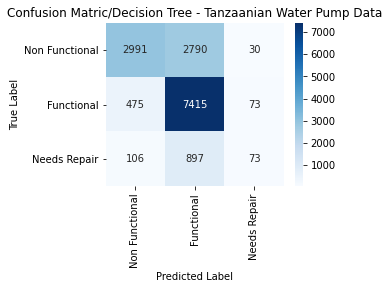

In [59]:
# Let's print the 5-Fold Cross Validation Scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Score: {}". format(round(np.mean(cv_scores),4)),
      ", Standard Devation: {}".format(round(np.std(cv_scores),4)))

plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,DTC.predict(X_test))
sns.heatmap(ConfMatrix, annot=True, cmap="Blues", fmt='d',
            xticklabels = ['Non Functional', 'Functional', 'Needs Repair'],
            yticklabels = ['Non Functional', 'Functional', 'Needs Repair'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matric/Decision Tree - Tanzaanian Water Pump Data");

In [60]:
# Let's Predict with Accuracy Evaluation for DTC
yhat= DTC.predict(X_test)
print('Training Set Accuracy: ', metrics.accuracy_score(y_train, DTC.predict(X_train)))
print('Test Set Accuracy: ', metrics.accuracy_score(y_test, yhat))


Training Set Accuracy:  0.7124579124579125
Test Set Accuracy:  0.7056565656565656


In [61]:
# Let's try KNN as the nest classifier
pipe_KNN = make_pipeline(StandardScaler(),
                         PCA(n_components=10),
                         KNeighborsClassifier(n_neighbors=10))
pipe_KNN.fit(X_train, y_train)
y=pred = pipe_KNN.predict(X_test)
print('Test Accuracy: %3f' % pipe_KNN.score(X_test, y_test))

# Cross Validation for KNN

scores = cross_val_score(estimator=pipe_KNN,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs = -1)

print('CV Accuracy Scores: %s' % scores)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Test Accuracy: 0.735690
CV Accuracy Scores: [0.73243547 0.73041526 0.735578   0.74074074 0.73804714 0.74163861
 0.73804714 0.73131313 0.73468013 0.73265993]
CV Accuracy: 0.736 +/- 0.004


**Next, let's see a comparison between the models.**

In [62]:
modelRFC = RandomForestClassifier(n_estimators=1000, min_samples_split=10, criterion='gini')
modelRFC.fit(X_train, y_train)

modelETC = ExtraTreesClassifier(n_estimators=1000, min_samples_split=10)
modelETC.fit(X_train, y_train)

modelDTC = DecisionTreeClassifier()
modelDTC.fit(X_train, y_train)

modelKNN = KNeighborsClassifier()
modelKNN.fit(X_train, y_train)

modelLR = LogisticRegression()
modelLR.fit(X_train, y_train)

scoreRFC = modelRFC.score(X_test, y_test)
scoreETC = modelETC.score(X_test, y_test)
scoreDTC = modelDTC.score(X_test, y_test)
scoreKNN = modelKNN.score(X_test, y_test)
scoreLR = modelLR.score(X_test, y_test)

print('Random Forest', scoreRFC)
print('Decision Tree', scoreDTC)
print('Extra Tree Classifier', scoreETC)
print('KNN', scoreKNN)
print('Logistic Regression', scoreLR)



Random Forest 0.806936026936027
Decision Tree 0.7408080808080808
Extra Tree Classifier 0.8025589225589226
KNN 0.7395286195286195
Logistic Regression 0.634006734006734


Text(0, 0.5, 'Score')

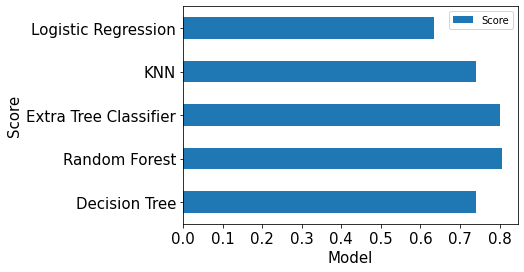

In [ ]:
# Let's see if we can graph it.
pd.DataFrame([("Decision Tree", scoreDTC),
              ("Random Forest", scoreRFC),
              ("Extra Tree Classifier", scoreETC),
              ("KNN", scoreKNN),
              ("Logistic Regression", scoreLR),],
              columns=["Model", "Score"]).plot(x="Model", y="Score", kind="barh", fontsize=15)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Score', fontsize=15)
            


Next, Let's try and build an individual Random Forest Classifier model run, and then fold in with Grid Search/Cross Validation Model.

In [65]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=7).fit(X_train, y_train)
yhatRF = rfc.predict(X_test)
print('Training Set Accuracy: ', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Testing Set Accuracy: ', metrics.accuracy_score(y_test, yhatRF))


Training Set Accuracy:  0.7371043771043772
Testing Set Accuracy:  0.7295622895622895


In [ ]:
# RFC with Grid Search and Cross Validation
rfc_params = {'n_estimators':[2,5,10,20,50,75,150],
              'criterion':['gini', 'entropy'],
              'max_depth':[2,5,10,20,50,None],
              'min_samples_split':[2,5,10,20]}

grid_RFC = GridSearchCV(RandomForestClassifier(),
                        rfc_params,
                        cv=5,
                        scoring='accuracy').fit(X_train, y_train)

yhatGS = grid_rfc.predict(X_test)

print('Training Set Accuracy: ', metrics.accuracy_score(y_train, grid_rfc.predict(X_train)))
print('Testing Set Accuracy: ', metrics.accuracy_score(y_test, yhatGS))


Training Set Accuracy:  0.9341638608305275
Testing Set Accuracy:  0.8054545454545454



              precision    recall  f1-score   support

           0       0.66      0.39      0.49      5811
           1       0.61      0.87      0.71      7963
           2       0.00      0.00      0.00      1076

    accuracy                           0.62     14850
   macro avg       0.42      0.42      0.40     14850
weighted avg       0.58      0.62      0.58     14850


Average 5-Fold CV Scores: 0.7332 , Standard Deviation: 0.0032


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


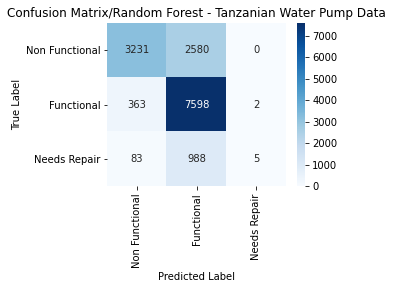

In [71]:
## 5-Fold Cross-Validation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rfc, X, y, cv=5)

# Print the 5-Fold Cross-Validation Scores
print()
print(classification_report(y_test, y_pred))
print()
print("Average 5-Fold CV Scores: {}".format(round(np.mean(cv_scores),4)),
      ", Standard Deviation: {}".format(round(np.std(cv_scores),4)))
plt.figure(figsize=(4,3))
ConfMatrix = confusion_matrix(y_test,rfc.predict(X_test))
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt='d',
            xticklabels = ['Non Functional', 'Functional', 'Needs Repair'],
            yticklabels = ['Non Functional', 'Functional', 'Needs Repair'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix/Random Forest - Tanzanian Water Pump Data");

         

Finally, let's run the test data through the model and make predictions.

In [84]:
X2 = subset_test.drop(columns = ['id']).values
yhat2 = modelKNN.predict(X2)
preds = pd.DataFrame(yhat2)
preds.head()

,0
0,1
1,1
2,1
3,1
4,1


In [85]:
subset_test.shape, preds.shape

((14850, 15), (14850, 1))

So, we have two dataframes the next step is to combine them into one dataframe. We will use the "concat" syntax to complete this action and combine the "id" column with the "status_group" column. Afterward, the next step is to export the prediction to a CSV file.

In [86]:
predict = pd.concat((water_test['id'], preds), axis=1)
predict.columns=['id', 'status_group']
predict['status_group'].unique()

array([1, 0])

In [87]:
predict.head()

,id,status_group
0,50785,1
1,51630,1
2,17168,1
3,45559,1
4,49871,1


In [88]:
predict.tail()

,id,status_group
14845,39307,0
14846,18990,1
14847,28749,1
14848,33492,1
14849,68707,1


In [89]:
# Let's export this to folder on my PC
predict.to_csv(r'C:\PANDAS\exportKNN_predict.csv', index=False, header=True)
print(predict)

          id  status_group
0      50785             1
1      51630             1
2      17168             1
3      45559             1
4      49871             1
...      ...           ...
14845  39307             0
14846  18990             1
14847  28749             1
14848  33492             1
14849  68707             1

[14850 rows x 2 columns]
